In [1]:
import numpy as np
import numpy.ma as ma
import argparse
import sys
sys.path.append("./utils/")
import operator_calculations as op_calc
import delay_embedding as embed
import stats
from scipy.interpolate import UnivariateSpline
from multiprocessing import Pool,cpu_count
import pickle
import h5py
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.io import loadmat

In [2]:
f = h5py.File('../data/DW/sims_fpts/metadata.h5','r')
Tx = np.array(f['Tx'])[0]
dt = np.array(f['dt'])[0]
tau_s = np.array(f['tau_s'])[0]
maxT = np.array(f['maxT'])[0]
f.close()
mu_s = np.sqrt(Tx)

In [3]:
Tx=1e-3
Ts_range = np.linspace(Tx/4,Tx*2,10)
indices = np.arange(10)

In [4]:
dts_Ts = []
idx=0
for Ts in Ts_range:
    dts=[]
    for k in indices:
        f = h5py.File('../data/DW/sims_fpts/combined_results_{}.h5'.format(idx),'r')
        fpts = np.array(f['fpts'])
        s_samples = np.array(f['s_sample'])
        f.close()
        dts.append(fpts)
        idx+=1
    dts_Ts.append(np.hstack(dts))

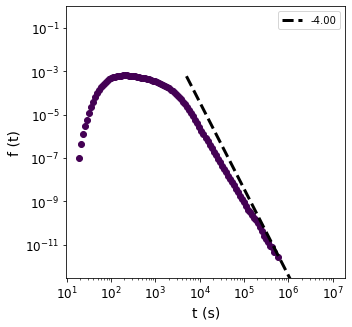

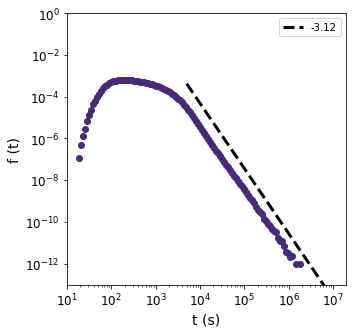

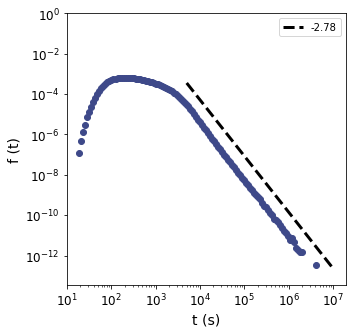

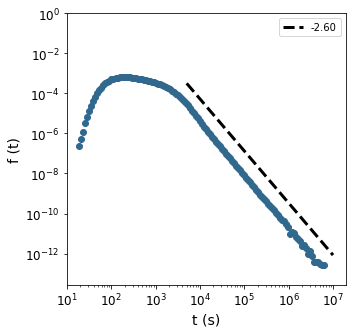

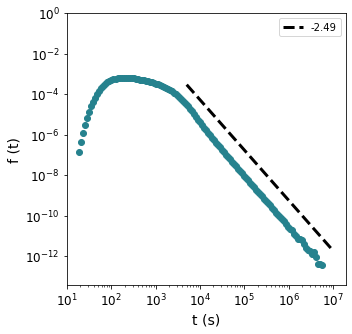

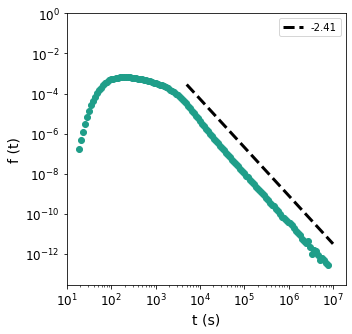

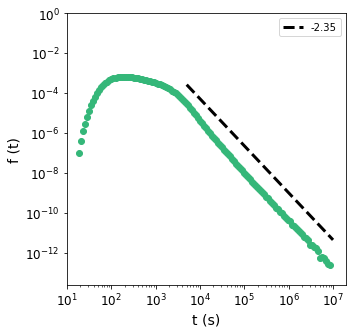

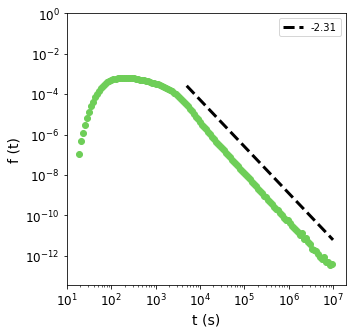

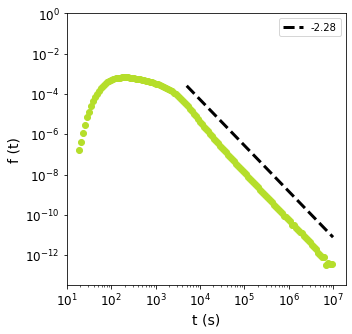

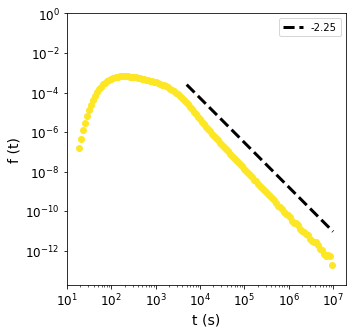

In [5]:
colors_Ts = plt.cm.viridis(np.linspace(0,1,len(Ts_range)))

for idx in range(len(Ts_range)):
    Ts = Ts_range[idx]
    f = h5py.File('../data/DW/sims_fpts/fptd_Ts_idx_{}.h5'.format(idx),'r')
    freqs = np.array(f['freqs'])
    centers_t = np.array(f['centers_t'])
    bins = np.array(f['bins'])
    f.close()
    
    db = np.array(np.diff(bins), float)
    prob = freqs/db/freqs.sum()
    sel = freqs>5
    prob = prob[sel]
    
    plt.figure(figsize=(5,5))
    plt.plot(centers_t[sel],prob,marker='o',lw=0,c=colors_Ts[idx])
    xmin=5e3
    trange = np.logspace(np.log10(xmin),7)
    alpha = 2+Tx/(2*Ts)
    plt.plot(trange,(alpha-1)/xmin*(trange/xmin)**(-alpha),label = '{:.2f}'.format(-alpha),c='k',ls='--',lw=3)
    plt.legend()
    plt.ylim(.1*np.min(prob),1)
    # plt.xlim(1e2,5e6)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('t (s)',fontsize=14)
    plt.ylabel('f (t)',fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
#     plt.savefig('fpts_Ts_{:.2f}.pdf'.format(Ts))
    plt.show()

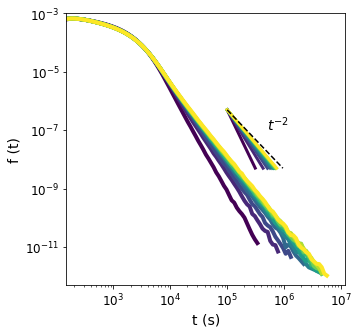

In [6]:

plt.figure(figsize=(5,5))
for idx in range(len(Ts_range)):
    Ts = Ts_range[idx]
    f = h5py.File('../data/DW/sims_fpts/fptd_Ts_idx_{}.h5'.format(idx),'r')
    freqs = np.array(f['freqs'])
    bins = np.array(f['bins'])
    centers_t = np.array(f['centers_t'])
    f.close()
    #normalize density
    db = np.array(np.diff(bins), float)
    prob = freqs/db/freqs.sum()
    sel = freqs>20
    prob = prob[sel]
    
    plt.plot(centers_t[sel],prob,c=colors_Ts[idx],lw=4)
    
    trange = np.logspace(3.5,6)
    plt.ylim(.1*np.min(prob),1)
    # plt.xlim(1e2,5e6)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('t (s)',fontsize=14)
    plt.ylabel('f (t)',fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
# plt.plot(trange,1e3*trange**(-2)*np.log(trange)**(-1/2),c='k',ls='--')
ymax = 5e-7
xmin = 1e5
trange = np.logspace(np.log10(xmin),7.5,1000)
ymin=5e-9
a = ymax*(xmin)**(2)*np.sqrt(np.log(xmin))
y = a*trange**(-2)*np.log(trange)**(-1/2)
sel = y>ymin
plt.plot(trange[sel],y[sel],c='k',ls='--',zorder=10)
for idx in range(len(Ts_range)):
    Ts = Ts_range[idx]
    a = ymax*(xmin)**(2+Tx/(2*Ts))*np.sqrt(np.log(xmin))
    y = a*trange**(-2-Tx/(2*Ts))*np.log(trange)**(-1/2)
    sel = y>ymin
    plt.plot(trange[sel],y[sel],c=colors_Ts[idx],lw=3)
plt.xlim(1.5e2,1.2e7)
plt.ylim(5e-13,1e-3)
plt.text(5e5,1e-7,r'$t^{{-2}}$',fontsize=14)
# plt.savefig('fptd_all_Ts_DW.pdf')
plt.show()

<ipython-input-7-cbb4a2cb86b2>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


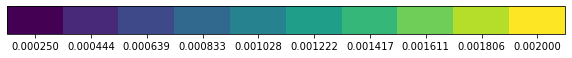

In [7]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.colors.ListedColormap(colors_Ts)
cmap.set_over('0.1')
cmap.set_under('1.0')

bounds =  np.hstack([Ts_range-np.diff(Ts_range)[0]/2,Ts_range[-1]+np.diff(Ts_range)[0]/2])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bounds,
                                ticks=Ts_range,
                                spacing='proportional',
                                orientation='horizontal')
# plt.savefig('colorbar_Ts_range.pdf')
fig.show()


In [8]:
def potential_x(x,s):
    return s**2*(x**2-1)**2

def potential_s(s,mu_s):
    return ((s-mu_s)**2)/2

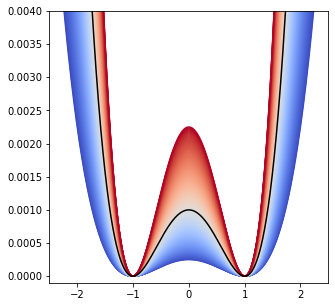

In [9]:
Ts=Ts_range[0]
xrange = np.linspace(-3.5,3.5,1000)
s_samples = np.linspace(mu_s-np.sqrt(Ts),mu_s+np.sqrt(Ts),200)
colors_s = plt.cm.coolwarm(np.linspace(0,1,len(s_samples)))
plt.figure(figsize=(5,5))
for ks,s in enumerate(np.sort(s_samples)):
    y = potential_x(xrange,s)
    sel = y<5e-3
    plt.plot(xrange[sel],y[sel],c=colors_s[ks])
y = potential_x(xrange,mu_s)
sel = y<5e-3
plt.plot(xrange[sel],y[sel],c='k')
plt.ylim(-1e-4,4e-3)
plt.xlim(-2.5,2.5)
# plt.savefig('DW_potential.pdf')
plt.show()